# Experimento 5 : Estudio de los efectos de implementar un STN


## Librerías usadas.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math 
from glob import glob
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

## Definición de rutas

In [2]:
#Rutas de los datos.
 
data_dir = os.path.dirname(os.path.realpath("../TFG/Datos/HAM10000_metadata.csv"))



csv_path = os.path.realpath(data_dir + "/HAM10000_metadata.csv")

#Variables globales

altura = 50
longitud = 50
clases = 7


print(data_dir)

print(csv_path)



/home/antgarnie/Escritorio/TFG/Datos
/home/antgarnie/Escritorio/TFG/Datos/HAM10000_metadata.csv


## Creación del marco de datos.

In [3]:
#Inicializando el dataFrame

dataFrame=pd.read_csv(csv_path)

#Mezclando carpetas.

all_image_path = glob(os.path.join(data_dir, '*', '*'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# Inicializando diccionario de categorías

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Añadiendo columnas al dataFrame para que sea más legible.

dataFrame['path'] = dataFrame['image_id'].map(imageid_path_dict.get)
dataFrame['cell_type'] = dataFrame['dx'].map(lesion_type_dict.get) 
dataFrame['cell_type_idx'] = pd.Categorical(dataFrame['cell_type']).codes
dataFrame.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,Benign keratosis,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,Benign keratosis,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,Benign keratosis,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,Benign keratosis,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/antgarnie/Escritorio/TFG/Datos/HAM10000_...,Benign keratosis,2


In [7]:
pip install stn

Note: you may need to restart the kernel to use updated packages.


## Preparación de la red



In [4]:
from stn import spatial_transformer_network as transformer

class Localization(tf.keras.layers.Layer):
    def __init__(self):
        super(Localization, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(32, activation='relu')
        self.dp1 = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dp1(x)
        theta = self.fc2(x)
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta
    
def conv_block(x,filters,kernel_size = (3,3),strides = (1,1),with_bn=False):
    x = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides)(x)
    if with_bn: 
        x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x)

def stn_block(x,output_size):
    theta = Localization()(x)
    x = transformer(x, theta, output_size) 
    return x
    

def full_build_cnn_soco(clases = 7,input_shape=(50, 50, 3),with_bn = False, with_dropout=False,stn=0):
    
    image = tf.keras.layers.Input(shape=input_shape)
    x = conv_block(image,32,with_bn=with_bn)
    x = conv_block(x,32,with_bn=with_bn)
    
    if(with_bn):
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = conv_block(x,64,with_bn=with_bn)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.PReLU()(x)
    
    if(with_dropout):
        x = tf.keras.layers.Dropout(0.5)(x)
    

    x = tf.keras.layers.Dense(clases,activation='softmax')(x)

    return tf.keras.models.Model(inputs=image, outputs=x)

def full_build_cnn_soco_v2(clases = 7,input_shape=(50, 50, 3),with_bn = False, with_dropout=False,stn=0):
    
    image = tf.keras.layers.Input(shape=input_shape)
    
    
    x = conv_block(x,32,with_bn=with_bn)
    
    
    if stn == 0:                
        x = stn_block(image,(int(64),int(64)))    
    if stn == 1:                 x = stn_block(x,(16,16))
    if stn == 2:                 x = stn_block(x,(32,32))
    if stn == 3:                 x = stn_block(x,(25,25))
        
    x = conv_block(x,32,kernel_size=(3,3),with_bn=with_bn)
    
    x = conv_block(x,64,with_bn=with_bn)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(16)(x)

    
    
    #if(with_bn):
        #x = tf.keras.layers.BatchNormalization()(x)
    if(with_dropout):
        x = tf.keras.layers.Dropout(0.5)(x)
    

    x = tf.keras.layers.Dense(clases,activation='softmax')(x)

    return tf.keras.models.Model(inputs=image, outputs=x)


def full_build_cnn_soco_v3(model,input_shape=(128, 128, 3)):
    
    image = tf.keras.layers.Input(shape=input_shape)
    x = stn_block(image,(int(50),int(50))) 
    x = model(x)
    
    return tf.keras.models.Model(inputs=image, outputs=x)


def full_build_cnn_soco_v4(clases = 7,with_bn = True, with_dropout=False,stn=0,input_shape=(128, 128, 3)):
    image = tf.keras.layers.Input(shape=input_shape)
    x = stn_block(image,(int(50),int(50))) 
    x = model(x)
    x = conv_block(x,32,with_bn=with_bn)
    
    
    if stn == 0:                
        x = stn_block(image,(int(64),int(64)))    
    if stn == 1:                 x = stn_block(x,(16,16))
    if stn == 2:                 x = stn_block(x,(32,32))
    if stn == 3:                 x = stn_block(x,(25,25))
        
    x = conv_block(x,32,kernel_size=(3,3),with_bn=with_bn)
    
    x = conv_block(x,64,with_bn=with_bn)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128)(x)

    
    
    #if(with_bn):
        #x = tf.keras.layers.BatchNormalization()(x)
    if(with_dropout):
        x = tf.keras.layers.Dropout(0.5)(x)
    

    x = tf.keras.layers.Dense(clases,activation='softmax')(x)
    return tf.keras.models.Model(inputs=image, outputs=x)

Building Localization Network with input shape: (None, 128, 128, 3)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(4,)]               0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [()]                 0           tf_op_layer_Shape[0][0]          
__________________________________________________________________________________________________
localization (Localization)     (None, 2, 3)         1862822     input_2[0][0]                    
___________________

In [39]:


cnn =[] 
cnn_stn =[] 

for element in res_without_fc_big:
    cnn.append(element[0])
    cnn_stn.append(element[1])

d = {'CNN':cnn ,'STN_CNN':cnn_stn}
df = pd.DataFrame(data=d)

print(df)
print(df.mean())

        CNN   STN_CNN
0  0.822757  0.817651
1  0.824216  0.825675
2  0.814004  0.814004
3  0.822757  0.825675
4  0.819110  0.816193
5  0.830780  0.827133
6  0.822757  0.824945
7  0.750547  0.755653
8  0.835886  0.832239
9  0.808899  0.813275
CNN        0.815171
STN_CNN    0.815244
dtype: float64


In [28]:
cnn =[] 
cnn_stn =[] 

for element in res_with_fc:
    cnn.append(element[0])
    cnn_stn.append(element[1])

d = {'CNN':cnn ,'STN_CNN':cnn_stn}
df = pd.DataFrame(data=d)

print(df)
print(df.mean())

        CNN   STN_CNN
0  0.816193  0.818381
1  0.830780  0.830780
2  0.820569  0.820569
3  0.840263  0.840992
4  0.830780  0.834427
5  0.777535  0.779723
6  0.825675  0.826404
7  0.814004  0.813275
8  0.780452  0.781911
9  0.794311  0.798687
CNN        0.813056
STN_CNN    0.814515
dtype: float64


In [25]:
cnn =[] 
cnn_stn =[] 

for element in res_with_fc:
    cnn.append(element[0])
    cnn_stn.append(element[1])
    
for element in res_without_fc:
    cnn.append(element[0])
    cnn_stn.append(element[1])

d = {'CNN':cnn ,'CNN_STN': cnn_stn}
df = pd.DataFrame(data=d)

print(df)
print(df.mean())

         CNN   CNN_STN
0   0.816193  0.818381
1   0.830780  0.830780
2   0.820569  0.820569
3   0.840263  0.840992
4   0.830780  0.834427
5   0.777535  0.779723
6   0.825675  0.826404
7   0.814004  0.813275
8   0.780452  0.781911
9   0.794311  0.798687
10  0.810357  0.811087
11  0.781182  0.777535
12  0.824216  0.823487
13  0.757841  0.757112
14  0.800146  0.799416
15  0.820569  0.825675
16  0.766594  0.766594
17  0.731583  0.727936
18  0.819840  0.819110
19  0.814734  0.815463
CNN        0.802881
CNN_STN    0.803428
dtype: float64


In [27]:
def resize_dataset(x_train,x_validation,x_test):
    x_train_small=[]
    x_value_small=[]
    x_test_small=[]


    for img in x_train:
        img = custom_resize(img,50)
        x_train_small.append(img)
        
    x_train_small = np.stack(x_train_small, axis=0)
        
    for img in x_validation:
        img = custom_resize(img,50)
        x_value_small.append(img)
    
    x_value_small = np.stack(x_value_small, axis=0)
        
    for img in x_test:
        img = custom_resize(img,50)
        x_test_small.append(img)
    
    x_test_small = np.stack(x_test_small, axis=0)
    
    return x_train_small,x_value_small,x_test_small

def train_proces_with_stn(x_train,x_validation,x_test,num_of_iterations=5,fixed_classificator=True):
    results = []
    for i in range(num_of_iterations):
    #First step
        opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
        x_train_small,x_value_small,x_test_small = resize_dataset(x_train,x_validation,x_test)
        res111,res112,evaluations,evaluations11,model = run_experiment(4,25,x_train_small,x_value_small,x_test_small,1)
        #for k,v in model._get_trainable_state().items():
            #k.trainable = False
        #model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
        model_stn = full_build_cnn_soco_v3(model,(128, 128, 3))
        opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
        earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                patience = 3,
                                                mode = 'min') 
        model_stn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        model_stn = model_stn.fit(x_train, y_train,validation_data=(x_validation, y_validation),epochs=20,callbacks=[earlyStopping],batch_size = BATCH_SIZE)
        evaluation = model_stn.model.evaluate(x_test, y_test)
        print(evaluations11[0][1],evaluation[1])
        results.append((evaluations11[0][1],evaluation[1]))
    return results

#res_without_fc_big = train_proces_with_stn(x_train,x_validation,x_test,fixed_classificator=False) 
res111,res112,evaluations,evaluations11,model = run_experiment(4,25,x_train,x_validation,x_test,1)

Epoch 1/25


ValueError: in user code:

    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:277 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/advanced_activations.py:161 call
        neg = -self.alpha * K.relu(-inputs)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:984 binary_op_wrapper
        return func(x, y, name=name)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:1283 _mul_dispatch
        return gen_math_ops.mul(x, y, name=name)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:6092 mul
        "Mul", x=x, y=y, name=name)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3327 _create_op_internal
        op_def=op_def)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1817 __init__
        control_input_ops, op_def)
    /home/antgarnie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1657 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 48 and 126 for '{{node sequential_8/p_re_lu_32/mul}} = Mul[T=DT_FLOAT](sequential_8/p_re_lu_32/Neg, sequential_8/p_re_lu_32/Relu_1)' with input shapes: [48,48,32], [12,126,126,32].


In [2]:
import tensorflow as tf
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Se procede a crear un método que permita balancear la carga de imágenes

In [5]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=2500,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

## Cargamos los datos y creamos los casos a experimentar.

In [6]:
def load_general_data(size):
    
    imgs, target = load_img_data(size, dataFrame, balanced=True)
    
    x_train, x_transferLearning, y_train, y_transferLearning = train_test_split(imgs, target, test_size=0.60)
       
    source_data = [ x_transferLearning , y_transferLearning ]
    target_data = [ x_train , y_train ]
    
    x_train,x_test,y_train,y_test = train_test_split(target_data[0], target_data[1], test_size=0.70)
    
    train_data = [x_train,y_train]
    test_data = [x_test,y_test]
    
    return source_data,train_data,test_data


def get_data_for_ex(source_data,train_data,test_data):
    
    x_train = source_data[0]
    y_train = source_data[1]
    
    x_retrain = train_data[0]
    y_retrain = train_data[1]
    
    percent = math.floor(len(test_data[0])/100*30)
       
    x_validation = test_data[0][0:percent]
    y_validation = test_data[1][0:percent]
    
    
    x_test = test_data[0][percent:-1]
    y_test = test_data[1][percent:-1]
    
    return x_train,x_retrain,x_test,x_validation,y_train,y_retrain,y_test,y_validation


###############################################################################################################
# Definimos 7 experimentos cada uno con un optimizador distingo y definimos el número de iteraciones          #
###############################################################################################################

ITERATIONS_PER_EXP = 10
BATCH_SIZE = 16
EPOCHS = 25
LEARNING_RATE=0.001

In [7]:
source_data,train_data,test_data = load_general_data(128)
x_train,x_retrain,x_test,x_validation,y_train,y_retrain,y_test,y_validation = get_data_for_ex(source_data,train_data,test_data)

100%|██████████| 17500/17500 [02:11<00:00, 132.82it/s]


(17500, 128, 128, 3)


In [26]:
def scheduler(epoch, lr):
    if epoch < 5:
        print(lr)
        return 0.001
    elif 5 >= epoch < 10:
        print(lr)
        return float(lr)*0.80
    elif 5 >= epoch < 15:
        print(lr)
        return float(lr)*0.70
    else:
        print(lr)
        return float(lr)*0.50
    return 0.0001


In [27]:
def scheduler(epoch, lr):
    return 0.001

In [ ]:
with tf.device('GPU:0'):
    res111,res112,evaluations,evaluations11 = run_experiment(4,x_train,x_validation,x_test,25)
#res121,res122,evaluations,evaluations12 = run_experiment(1,25)
#res131,res132,evaluations,evaluations13 = run_experiment(2,25)
#res141,res142,evaluations,evaluations14 = run_experiment(3,25)

In [138]:
#Experimento 3. Red con soco con BN y sin Dropout.

res11,res12,evaluations,evaluations1 = run_experiment(0,25)
res21,res22,evaluations,evaluations2 = run_experiment(1,25)
res31,res32,evaluations,evaluations3 = run_experiment(2,25)
res41,res42,evaluations,evaluations4 = run_experiment(3,25)


Building Localization Network with input shape: (None, 44, 44, 32)
Epoch 1/25
875/875 [==============================] - 76s 87ms/step - loss: 1.1329 - accuracy: 0.5803 - val_loss: 1.0896 - val_accuracy: 0.5925
Epoch 2/25
875/875 [==============================] - 75s 86ms/step - loss: 0.6893 - accuracy: 0.7564 - val_loss: 1.7701 - val_accuracy: 0.4707
Epoch 3/25
875/875 [==============================] - 76s 87ms/step - loss: 0.4749 - accuracy: 0.8343 - val_loss: 0.5763 - val_accuracy: 0.7959
Epoch 4/25
875/875 [==============================] - 76s 86ms/step - loss: 0.3268 - accuracy: 0.8886 - val_loss: 0.4377 - val_accuracy: 0.8401
Epoch 5/25
875/875 [==============================] - 76s 87ms/step - loss: 0.2314 - accuracy: 0.9216 - val_loss: 0.4281 - val_accuracy: 0.8517
Epoch 6/25
875/875 [==============================] - 76s 87ms/step - loss: 0.1738 - accuracy: 0.9433 - val_loss: 0.9363 - val_accuracy: 0.6946
Epoch 7/25
875/875 [==============================] - 76s 87ms/step -

875/875 [==============================] - 78s 89ms/step - loss: 0.0365 - accuracy: 0.9895 - val_loss: 0.3184 - val_accuracy: 0.9054
Epoch 13/25
875/875 [==============================] - 78s 89ms/step - loss: 0.0276 - accuracy: 0.9930 - val_loss: 0.2124 - val_accuracy: 0.9408
Epoch 14/25
875/875 [==============================] - 78s 89ms/step - loss: 0.0261 - accuracy: 0.9927 - val_loss: 0.3653 - val_accuracy: 0.8986
Epoch 15/25
875/875 [==============================] - 78s 89ms/step - loss: 0.0333 - accuracy: 0.9905 - val_loss: 0.3402 - val_accuracy: 0.9156
3429
108/108 [==============================] - 5s 43ms/step - loss: 0.4372 - accuracy: 0.8889
Epoch 1/25
875/875 [==============================] - 17s 19ms/step - loss: 0.0259 - accuracy: 0.9931 - val_loss: 0.2501 - val_accuracy: 0.9395
Epoch 2/25
875/875 [==============================] - 17s 19ms/step - loss: 0.0145 - accuracy: 0.9983 - val_loss: 0.2501 - val_accuracy: 0.9395
Epoch 3/25
875/875 [=============================

875/875 [==============================] - 16s 19ms/step - loss: 2.7481e-05 - accuracy: 1.0000 - val_loss: 0.3426 - val_accuracy: 0.9435
Epoch 6/25
108/108 [==============================] - 4s 41ms/step - loss: 0.4061 - accuracy: 0.9323
########################################################
Iteración 2 de 5
########################################################
Building Localization Network with input shape: (None, 44, 44, 32)
Epoch 1/25
875/875 [==============================] - 78s 89ms/step - loss: 1.1261 - accuracy: 0.5874 - val_loss: 0.9046 - val_accuracy: 0.6653
Epoch 2/25
875/875 [==============================] - 77s 88ms/step - loss: 0.6919 - accuracy: 0.7588 - val_loss: 0.7548 - val_accuracy: 0.7306
Epoch 3/25
875/875 [==============================] - 78s 89ms/step - loss: 0.3885 - accuracy: 0.8687 - val_loss: 0.8047 - val_accuracy: 0.7184
Epoch 4/25
875/875 [==============================] - 77s 89ms/step - loss: 0.2503 - accuracy: 0.9161 - val_loss: 0.9561 - val_accur

Epoch 8/25
875/875 [==============================] - 103s 118ms/step - loss: 0.0217 - accuracy: 0.9950 - val_loss: 0.2139 - val_accuracy: 0.9463
Epoch 9/25
875/875 [==============================] - 103s 118ms/step - loss: 0.0158 - accuracy: 0.9969 - val_loss: 0.2426 - val_accuracy: 0.9408
Epoch 10/25
875/875 [==============================] - 104s 118ms/step - loss: 0.0099 - accuracy: 0.9987 - val_loss: 0.2349 - val_accuracy: 0.9429
Epoch 11/25
875/875 [==============================] - 103s 118ms/step - loss: 0.0116 - accuracy: 0.9976 - val_loss: 0.2564 - val_accuracy: 0.9456
Epoch 12/25
875/875 [==============================] - 103s 118ms/step - loss: 0.0090 - accuracy: 0.9988 - val_loss: 0.2468 - val_accuracy: 0.9456
3429
108/108 [==============================] - 6s 58ms/step - loss: 0.2744 - accuracy: 0.9326
Epoch 1/25
875/875 [==============================] - 22s 26ms/step - loss: 2.2211e-04 - accuracy: 1.0000 - val_loss: 0.2996 - val_accuracy: 0.9442
Epoch 2/25
875/875 [====

875/875 [==============================] - 88s 101ms/step - loss: 0.2034 - accuracy: 0.9348 - val_loss: 0.3695 - val_accuracy: 0.8789
Epoch 6/25
875/875 [==============================] - 88s 101ms/step - loss: 0.1357 - accuracy: 0.9595 - val_loss: 0.4234 - val_accuracy: 0.8599
Epoch 7/25
875/875 [==============================] - 88s 101ms/step - loss: 0.1135 - accuracy: 0.9654 - val_loss: 0.4774 - val_accuracy: 0.8510
Epoch 8/25
875/875 [==============================] - 88s 101ms/step - loss: 0.0772 - accuracy: 0.9767 - val_loss: 0.2414 - val_accuracy: 0.9279
Epoch 9/25
875/875 [==============================] - 88s 101ms/step - loss: 0.0534 - accuracy: 0.9854 - val_loss: 0.2306 - val_accuracy: 0.9354
Epoch 10/25
875/875 [==============================] - 88s 101ms/step - loss: 0.0379 - accuracy: 0.9906 - val_loss: 0.2619 - val_accuracy: 0.9320
Epoch 11/25
875/875 [==============================] - 88s 101ms/step - loss: 0.0359 - accuracy: 0.9908 - val_loss: 0.3221 - val_accuracy: 0

In [9]:
def run_train(nn_base_arch,epochs,checkpoint,dense = False):
    nn = select_network(nn_base_arch)
    
    if dense == True :
        model = build_dense(nn)
    else:
        model = build(nn)
        
    cpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="val_loss", mode="min", save_best_only=True, verbose=0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy','mse'])
    
    history = model.fit(x_train, y_train,epochs=EPOCHS,callbacks=[cpoint],batch_size = BATCH_SIZE,verbose=0)
      
    evaluation = model.evaluate(x_test, y_test)
        
    return history,evaluation

def run_train_w_model(model,x_train,x_validation,x_test,epochs,output_layer):
        
    opt = tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True)
    
    cbs = tf.keras.callbacks.LearningRateScheduler(scheduler)
        
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                patience = 3,
                                                mode = 'min')    
    
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,validation_data=(x_validation, y_validation),epochs=epochs,
                        callbacks=[earlyStopping,cbs],batch_size = BATCH_SIZE)
    
    print(len(x_test))
    
    evaluation = model.evaluate(x_test, y_test)
        
    return history,evaluation,model
    
def re_train(model,x_train,x_validation,x_test,checkpoint,epochs):
    
    cbs = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True)

    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                patience = 3,
                                                mode = 'min')    
    
    cpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint,
                                                monitor="val_loss",
                                                mode="min",
                                                save_best_only=True,
                                                verbose=0)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(x_train, y_train,validation_data=(x_validation, y_validation),epochs=epochs,callbacks=[earlyStopping,cbs],batch_size = BATCH_SIZE)
    evaluation = model.evaluate(x_test, y_test)
    return history,evaluation,model

In [29]:
def full_build_cnn_soco(with_bn = False, withDropout=False):
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, (3,3),(1,1),input_shape=(altura,longitud,3)))
    model.add(tf.keras.layers.PReLU())
    if(with_bn):
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(32, (3,3),(1,1)))
    model.add(tf.keras.layers.PReLU())
    if(with_bn):
        model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.MaxPooling2D((2,2)))

 
    model.add(tf.keras.layers.Conv2D(64, (3,3)))
    model.add(tf.keras.layers.PReLU())
    if(with_bn):
        model.add(tf.keras.layers.BatchNormalization())
        
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.PReLU())
    if(withDropout):
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))

    return model

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler
def run_experiment(index_model,epoch,x_train,x_validation,x_test,iterations = 1):
    result = []
    result_post_tf = []
    evaluations = []
    evaluations_post_tf = []
    dense = False
    
    for i in range(iterations):
        checkpoint ="../TFG/Modelos/balanced_model_sl_"+str(i)+"_EXP3.h5"
        
        if index_model == 0:
            model = full_build_cnn_soco_v2(7,(50, 50, 3), with_bn = True, with_dropout=False,stn=0)
        if index_model == 1:
            model = full_build_cnn_soco_v2(7,(50, 50, 3), with_bn = True, with_dropout=False,stn=1)
        if index_model == 2:
            model = full_build_cnn_soco_v2(7,(50, 50, 3), with_bn = True, with_dropout=False,stn=2)
        if index_model == 3:
            model = full_build_cnn_soco_v2(7,(50, 50, 3), with_bn = True, with_dropout=False,stn=3)
        if index_model == 4:
            model = full_build_cnn_soco(with_bn = True, withDropout=False)
        
        h,e,tf_model = run_train_w_model(model,x_train,x_validation,x_test,epoch,dense)
        
        result.append(h)
        evaluations.append(e)

        layers = tf_model.layers[0:-1]
        for layer in layers:
            layer.trainable = False
            
        h_retrain,e_retrain,model = re_train(tf_model,x_train,x_validation,x_test,checkpoint,epoch)

        result_post_tf.append(h_retrain)
        evaluations_post_tf.append(e_retrain)
        
        
        
        print("########################################################")
        print("Iteración "+str(i+1) +" de "+ str(iterations))
        print("########################################################")
        
    return result,result_post_tf,evaluations,evaluations_post_tf,model

## Métodos de representación gráfica

In [78]:
def plot_acc_for_ex1_w_test_score(res,evaluations,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
            
        plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc")
        plt.plot(5,evaluations[i][1],'bo')
        
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [24]:
def plot_acc_for_ex1(res,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
            
        plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc")
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [24]:
def plot_acc_for_experiments(res,res1,evaluations,evaluations1,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
        
        precisiones1=[]
        precisiones1.append(0.0)
        for e in res1[i].history["accuracy"]:
            precisiones1.append(e)
        
        if i == 0:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc",color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1], label="train_acc",color='blue')
        else:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1],color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1],color='blue')
            plt.plot(5,evaluations[i][1],'bo',color='green')
            plt.plot(5,evaluations1[i][1],'bo',color='blue')
        
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.savefig("Exp_1_"+"Training "+str(value)+" and validation "+str(value)+".jpg")
    plt.legend()
    plt.show()

In [40]:
def plot_trainAcc_vs_valAcc_for_experiments(res,res1,epochs,name,value="loss"):
    plt.figure(figsize=(12,8))
    
    for i in range(len(range(10))):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history[value]:
            precisiones.append(e)
            
        #precisiones.append(0.0)
        for e in res1[i].history[value]:
            precisiones.append(e)
        
        precisiones1=[]
        precisiones1.append(0.0)
        for e in res[i].history["val_"+str(value)]:
            precisiones1.append(e)

        #precisiones1.append(0.0)
        for e in res1[i].history["val_"+str(value)]:
            precisiones1.append(e)
        
        if i == 0:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_"+str(value),color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1], label="val_"+str(value),color='blue')
        else:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1],color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1],color='blue')
        
    plt.title("Training "+str(value)+" and validation "+str(value))
    plt.xlabel("Epoch")
    plt.ylabel(str(value).capitalize())
    plt.legend()
    plt.savefig("Exp_1_BN_"+"Training "+str(value)+" and validation "+str(value)+".jpg")
    plt.show()

IndexError: list index out of range

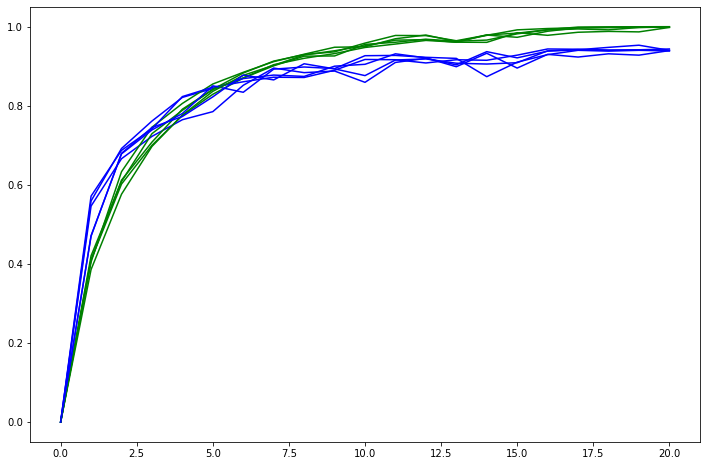

In [41]:
plot_trainAcc_vs_valAcc_for_experiments(res31,res32,20,"","accuracy")

## Representamos gráficamente los resultados obtenidos al experimentar con el tamaño del lote

In [107]:
def compute_values(resx1,resx2,i,val):
    res=[]
    if val != "val_loss":
        res.append(0.0)
    for e in resx1[i].history[val]:
        res.append(e)
    for e in resx2[i].history[val]:
        res.append(e)
    return res




def plot_acc_all_experiments(res11,res12,res21,res22,res31,res32,epochs):
    plt.figure(figsize=(16,10))
    
    acc = "val_accuracy"
    
    for i in range(10):
        
        precisiones = compute_values(res11,res12,i,acc)
            
        precisiones1 = compute_values(res21,res22,i,acc)
        
        precisiones2 = compute_values(res31,res32,i,acc)
        
        
        loss = compute_values(res11,res12,i,"val_loss")
        
        loss1 = compute_values(res21,res22,i,"val_loss")
        
        loss2 = compute_values(res31,res32,i,"val_loss")
        

        if i == 0:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="Dropout",color='green')
            #plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1], label="BachNormalization y Dropout",color='blue')
            plt.plot(np.arange(0, epochs+1), precisiones2[0:epochs+1], label="BachNormalization sin Dropout",color='red')
            #plt.plot(np.arange(0, epochs+1), precisiones3[0:epochs+1], label="Amsgrad",color='aqua')
            #plt.plot(np.arange(0, epochs+1), precisiones4[0:epochs+1], label="Adamax",color='red')
            #plt.plot(np.arange(0, epochs+1), precisiones5[0:epochs+1], label="Nadam",color='deeppink')
            #plt.plot(np.arange(0, epochs+1), precisiones6[0:epochs+1], label="Adadelta",color='yellowgreen')
            
            plt.plot(np.arange(0, epochs+1), loss[0:epochs+1],color='green')
            #plt.plot(np.arange(0, epochs+1), loss1[0:epochs+1],color='blue')
            plt.plot(np.arange(0, epochs+1), loss2[0:epochs+1],color='red')
            #plt.plot(np.arange(0, epochs+1), loss3[0:epochs+1],color='aqua')
            #plt.plot(np.arange(0, epochs+1), loss4[0:epochs+1], label="Adamax",color='red')
            #plt.plot(np.arange(0, epochs+1), loss5[0:epochs+1], label="Nadam",color='deeppink')
            #plt.plot(np.arange(0, epochs+1), loss6[0:epochs+1], label="Adadelta",color='yellowgreen')
            
        else:
            
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1],color='green')
            #plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1],color='blue')
            plt.plot(np.arange(0, epochs+1), precisiones2[0:epochs+1],color='red')
            #plt.plot(np.arange(0, epochs+1), precisiones3[0:epochs+1],color='aqua')
            #plt.plot(np.arange(0, epochs+1), precisiones4[0:epochs+1], label="Adamax",color='red')
            #plt.plot(np.arange(0, epochs+1), precisiones5[0:epochs+1], label="Nadam",color='deeppink')
            #plt.plot(np.arange(0, epochs+1), precisiones6[0:epochs+1], label="Adadelta",color='yellowgreen')
            
            plt.plot(np.arange(0, epochs+1), loss[0:epochs+1],color='green')
            #plt.plot(np.arange(0, epochs+1), loss1[0:epochs+1],color='blue')
            plt.plot(np.arange(0, epochs+1), loss2[0:epochs+1],color='red')
            #plt.plot(np.arange(0, epochs+1), loss3[0:epochs+1],color='aqua')
            #plt.plot(np.arange(0, epochs+1), loss4[0:epochs+1],color='red')
            #plt.plot(np.arange(0, epochs+1), loss5[0:epochs+1],color='deeppink')
            #plt.plot(np.arange(0, epochs+1), loss6[0:epochs+1],color='yellowgreen')
            
        del precisiones
        del precisiones1
        del precisiones2


        
    plt.title("Training Accuracy and Test Results")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig("Exp_1_2_kinds.jpg")
    plt.show()
#RMSProp,SGD,Adam,Amsgrad,Adamax,Nadam,Adadelta

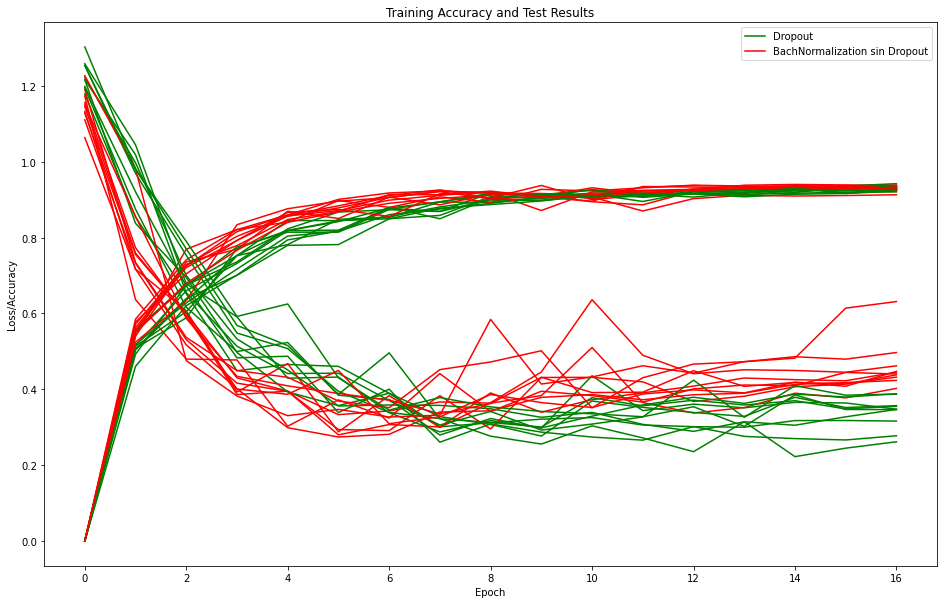

In [108]:
plot_acc_all_experiments(res11,res12,res21,res22,res31,res32,16)

## Creamos marcos de datos para analizar los resultados de evaluar los modelos 

In [154]:
precision1 = []
precision2 = []
precision3 = []
precision4 = []
precision5 = []


for e in evaluations11:
    element = e[1]
    precision1.append(element)
    
for e in evaluations12:
    element = e[1]
    precision2.append(element)
    
for e in evaluations13:
    element = e[1]
    precision3.append(element)
    

    
d = {'0': precision1,'1': precision2,'2': precision3}
df = pd.DataFrame(data=d)

print(df)
print(df.mean())

          0         1         2
0  0.907553  0.144065  0.930300
1  0.841062  0.892972  0.928551
2  0.890639  0.935258  0.932633
3  0.909011  0.930884  0.932342
4  0.920968  0.925634  0.933800
0    0.893847
1    0.765763
2    0.931525
dtype: float64


In [200]:
batch_size = 12
num_epochs = 20
output_STN = model.get_layer('tf_op_layer_AddN_43').output
val_data = (x_validation,y_validation)
STN_function = tf.keras.backend.function(model.input,[output_STN])
test_data = (x_test,y_test)
for epoch_arg in range(num_epochs):
    for batch_arg in range(150):
        arg_0 = batch_arg * batch_size
        arg_1 = (batch_arg + 1) * batch_size
        x_batch, y_batch = x_train[arg_0:arg_1], y_train[arg_0:arg_1]
        loss = model.train_on_batch(x_batch, y_batch)
    if epoch_arg % 10 == 0:
        val_score = model.evaluate(*val_data, verbose=1)
        test_score = model.evaluate(*test_data, verbose=1)
        print_evaluation(epoch_arg, val_score, test_score)
        plot_mnist_grid(x_batch, STN_function)
        print('-' * 40)

43/43 [==============================] - 3s 66ms/step - loss: 1.9471 - accuracy: 0.1495
Epoch: 0 | Val: [1.9478473663330078, 0.14965985715389252] | Test: [1.9471158981323242, 0.14952589571475983]


InvalidArgumentError: input must be 4-dimensional[128,128,3] [Op:Conv2D]

<Figure size 432x288 with 0 Axes>

In [163]:
def stn_model(input_shape=(128, 128, 3),with_bn = False):
    image = tf.keras.layers.Input(shape=input_shape)
    theta = Localization()(image)
    x = transformer(image, theta, (64,64,3))
    x = tf.keras.layers.Dense(clases,activation='softmax')(x)
    return tf.keras.models.Model(inputs=image, outputs=x)

In [189]:

model = full_build_cnn_soco_v2(clases = 7,input_shape=(128, 128, 3),with_bn = False, with_dropout=False,stn=0)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
   
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Building Localization Network with input shape: (None, 128, 128, 3)


In [186]:
model.summary()

Model: "functional_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 126, 126, 32) 896         input_50[0][0]                   
__________________________________________________________________________________________________
re_lu_41 (ReLU)                 (None, 126, 126, 32) 0           conv2d_141[0][0]                 
__________________________________________________________________________________________________
tf_op_layer_Shape_420 (TensorFl [(4,)]               0           re_lu_41[0][0]                   
______________________________________________________________________________________

In [177]:
output_STN = model.get_layer('tf_op_layer_AddN_42').output

<function tensorflow.python.keras.backend.function.<locals>.func(model_inputs)>

In [160]:


    
model = model_stn.fit(x_train, y_train,validation_data=(x_validation, y_validation),epochs=1,batch_size = 12)

ValueError: in user code:

    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1566 sparse_categorical_crossentropy
        return K.sparse_categorical_crossentropy(
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4782 sparse_categorical_crossentropy
        res = nn.sparse_softmax_cross_entropy_with_logits_v2(
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:4174 sparse_softmax_cross_entropy_with_logits_v2
        return sparse_softmax_cross_entropy_with_logits(
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/antoniojesus/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:4087 sparse_softmax_cross_entropy_with_logits
        raise ValueError("Shape mismatch: The shape of labels (received %s) "

    ValueError: Shape mismatch: The shape of labels (received (12,)) should equal the shape of logits except for the last dimension (received (49152, 3)).


(128, 128, 3)


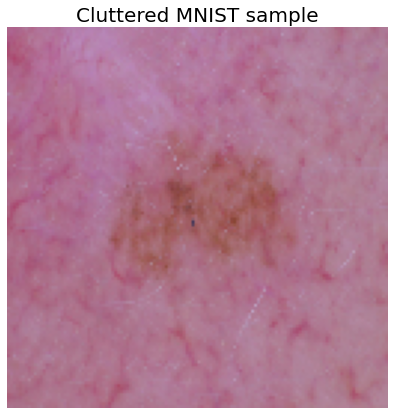

In [31]:
plot_sample(x_train[5])


In [ ]:
STN_function = tf.keras.backend.function(model.input,[output_STN])
image =STN_function(x_train)

In [10]:
def custom_resize(sample,size):
    image = cv2.resize(sample,(size,size))
    sample = np.array(image)
    return sample

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample(sample):
    #mnist_sample = np.squeeze(mnist_sample)
    image = cv2.resize(sample,(50,50))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample = np.array(image)
    print(sample.shape)
    plt.figure(figsize=(7, 7))
    plt.imshow(sample)
    plt.title('Cluttered MNIST sample', fontsize=20)
    plt.axis('off')
    plt.show()


def plot_mnist_grid(image_batch, function=None):
    fig = plt.figure()
    if function is not None:
        
        image = cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB)
        sample = np.array(image)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else: 
        print("--------------------------------------")


def print_evaluation(epoch_arg, val_score, test_score):
    message = 'Epoch: {0} | Val: {1} | Test: {2}'
    print(message.format(epoch_arg, val_score, test_score))

(50, 50, 3)


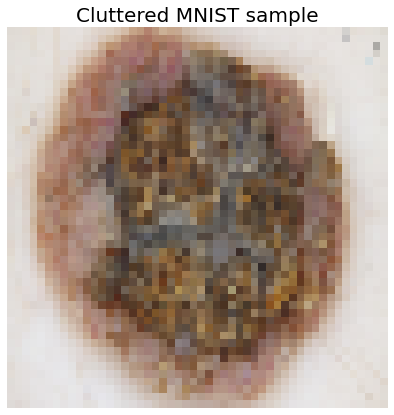

In [81]:
plot_sample(x_train_small[2])